In [ ]:
#import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# **Loading the data**

In [ ]:
folder_path='/content/gdrive/My Drive/Data Science journey/Kaggle competitions/House Prices - Advanced Regression Techniques/'
file_path_train=folder_path+'train.csv'
file_path_test=folder_path+'test.csv'

print(file_path_train)
print(file_path_test)

/content/gdrive/My Drive/Data Science journey/Kaggle competitions/House Prices - Advanced Regression Techniques/train.csv
/content/gdrive/My Drive/Data Science journey/Kaggle competitions/House Prices - Advanced Regression Techniques/test.csv


In [ ]:
# connect to Google Drive
drive.mount('/content/gdrive')
open(file_path_train).read()
open(file_path_test).read()

In [ ]:
df_train=pd.read_csv(file_path_train)
df_test=pd.read_csv(file_path_test)

# **Exploring the datasets**

In [ ]:
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


<Axes: xlabel='SalePrice', ylabel='Count'>

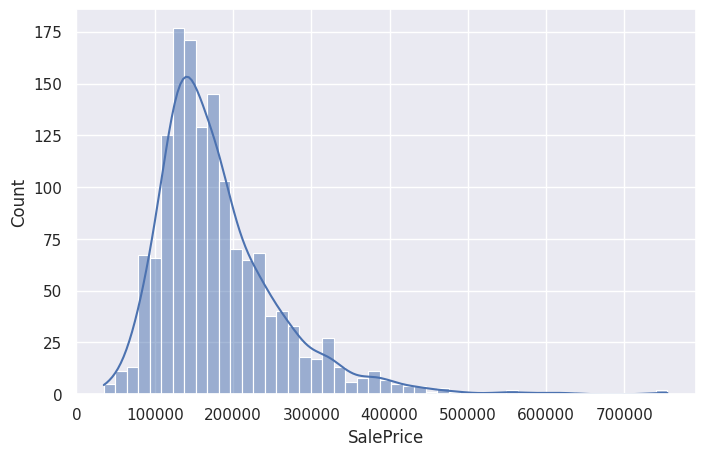

In [ ]:
# let's look at the house price distribution in the training dataset
plt.figure(figsize=(8, 5))
sns.histplot(df_train['SalePrice'], kde=True)

In [ ]:
df_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [ ]:
# set 'Id' as the index
df_train.set_index('Id',inplace=True)
df_test.set_index('Id',inplace=True)

# **TensorFlow Decision Forest (TF-DF)**

There's one more step required before we can train the model. We need to convert the datatset from Pandas format (pd.DataFrame) into TensorFlow Datasets format (tf.data.Dataset).

In [ ]:
val_ratio=0.2
training_set, validation_set = train_test_split(df_train, test_size=val_ratio, random_state=42)

print(training_set.shape, validation_set.shape)

(1168, 80) (292, 80)


In [ ]:
label = 'SalePrice'
task = tfdf.keras.Task.REGRESSION

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(training_set, label=label, task = task)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(validation_set, label=label, task = task)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = task)
rf.compile(metrics=["mse"]) # to include a list of eval metrics

Use /tmp/tmpbr5j9lvo as temporary training directory


In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:03.353018. Found 1168 examples.
Training model...
Model trained in 0:00:03.718085
Compiling model...
Model compiled.


In [ ]:
# One benefit of tree-based models is that you can easily visualize them.
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

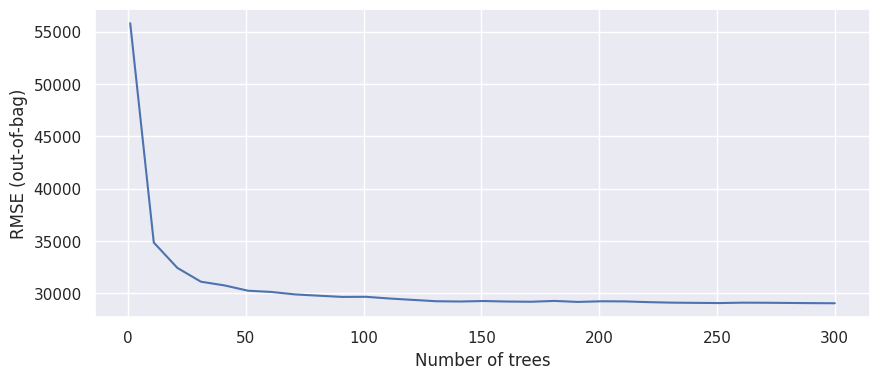

In [ ]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1168, accuracy=None, loss=None, rmse=29038.83393673359, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 735ms/step - loss: 0.0000e+00 - mse: 818550848.0000
loss: 0.0000
mse: 818550848.0000


# **Feature importances**

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [ ]:
inspector.variable_importances()["INV_MEAN_MIN_DEPTH"]

[("OverallQual" (1; #62), 0.2318131400917813),
 ("GrLivArea" (1; #38), 0.20226296388291415),
 ("Neighborhood" (4; #59), 0.2001946405873128),
 ("GarageCars" (1; #32), 0.12951885462820845),
 ("TotalBsmtSF" (1; #73), 0.1292305812357671),
 ("1stFlrSF" (1; #0), 0.12496417021828735),
 ("ExterQual" (4; #22), 0.12203608815633156),
 ("GarageArea" (1; #31), 0.11861574619515572),
 ("YearBuilt" (1; #76), 0.11589793153873373),
 ("BsmtFinSF1" (1; #8), 0.11344700357171904),
 ("2ndFlrSF" (1; #1), 0.11135753173879699),
 ("LotArea" (1; #47), 0.11124363107686285),
 ("KitchenQual" (4; #44), 0.10851674835880919),
 ("BsmtQual" (4; #14), 0.10535390303163983),
 ("YearRemodAdd" (1; #77), 0.10513650169138902),
 ("Fireplaces" (1; #27), 0.10503967577982684),
 ("FullBath" (1; #29), 0.10472176047700484),
 ("GarageFinish" (4; #34), 0.10421901666806749),
 ("CentralAir" (4; #16), 0.10312583957692209),
 ("BsmtFinType1" (4; #10), 0.10288405190414156),
 ("Exterior1st" (4; #23), 0.10284278120847234),
 ("Exterior2nd" (4; #

In [ ]:
inspector.variable_importances()["SUM_SCORE"]

[("OverallQual" (1; #62), 534139699755050.5),
 ("Neighborhood" (4; #59), 239638608285668.84),
 ("GrLivArea" (1; #38), 228668269247139.7),
 ("GarageCars" (1; #32), 157657796475438.75),
 ("ExterQual" (4; #22), 152312469196797.5),
 ("TotalBsmtSF" (1; #73), 71047054584037.1),
 ("1stFlrSF" (1; #0), 64967749757492.69),
 ("YearBuilt" (1; #76), 60335060527958.16),
 ("KitchenQual" (4; #44), 56986079324630.5),
 ("GarageArea" (1; #31), 49277618488719.414),
 ("BsmtQual" (4; #14), 48265298064831.25),
 ("BsmtFinSF1" (1; #8), 47394001638822.875),
 ("2ndFlrSF" (1; #1), 38292101330629.28),
 ("LotArea" (1; #47), 29472248035899.297),
 ("FullBath" (1; #29), 19378500037522.61),
 ("TotRmsAbvGrd" (1; #72), 18623267576518.188),
 ("Exterior1st" (4; #23), 13869764095527.781),
 ("Exterior2nd" (4; #24), 12644892513624.0),
 ("YearRemodAdd" (1; #77), 12110758048833.938),
 ("Fireplaces" (1; #27), 11591075166608.281),
 ("GarageFinish" (4; #34), 10890973288434.688),
 ("LotFrontage" (1; #49), 8818762079085.438),
 ("Bsm

In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 108.0),
 ("ExterQual" (4; #22), 54.0),
 ("GarageCars" (1; #32), 40.0),
 ("Neighborhood" (4; #59), 34.0),
 ("YearBuilt" (1; #76), 17.0),
 ("GrLivArea" (1; #38), 16.0),
 ("KitchenQual" (4; #44), 15.0),
 ("BsmtQual" (4; #14), 6.0),
 ("GarageArea" (1; #31), 4.0),
 ("TotalBsmtSF" (1; #73), 4.0),
 ("1stFlrSF" (1; #0), 1.0),
 ("BsmtFinSF1" (1; #8), 1.0)]

In [ ]:
inspector.variable_importances()["NUM_NODES"]

[("Neighborhood" (4; #59), 4617.0),
 ("GrLivArea" (1; #38), 4218.0),
 ("TotalBsmtSF" (1; #73), 2727.0),
 ("LotArea" (1; #47), 2717.0),
 ("GarageArea" (1; #31), 2613.0),
 ("1stFlrSF" (1; #0), 2229.0),
 ("BsmtFinSF1" (1; #8), 2207.0),
 ("Exterior2nd" (4; #24), 1997.0),
 ("BsmtUnfSF" (1; #15), 1869.0),
 ("YearRemodAdd" (1; #77), 1782.0),
 ("BsmtFinType1" (4; #10), 1724.0),
 ("Exterior1st" (4; #23), 1639.0),
 ("OverallQual" (1; #62), 1467.0),
 ("LotFrontage" (1; #49), 1436.0),
 ("OpenPorchSF" (1; #60), 1401.0),
 ("YearBuilt" (1; #76), 1368.0),
 ("MoSold" (1; #58), 1300.0),
 ("2ndFlrSF" (1; #1), 1200.0),
 ("GarageYrBlt" (1; #37), 1178.0),
 ("WoodDeckSF" (1; #75), 1177.0),
 ("MasVnrArea" (1; #54), 1093.0),
 ("OverallCond" (1; #61), 962.0),
 ("YrSold" (1; #78), 926.0),
 ("BsmtExposure" (4; #7), 761.0),
 ("HeatingQC" (4; #41), 761.0),
 ("TotRmsAbvGrd" (1; #72), 704.0),
 ("GarageFinish" (4; #34), 552.0),
 ("LotConfig" (4; #48), 514.0),
 ("HouseStyle" (4; #42), 478.0),
 ("GarageCars" (1; #32), 4

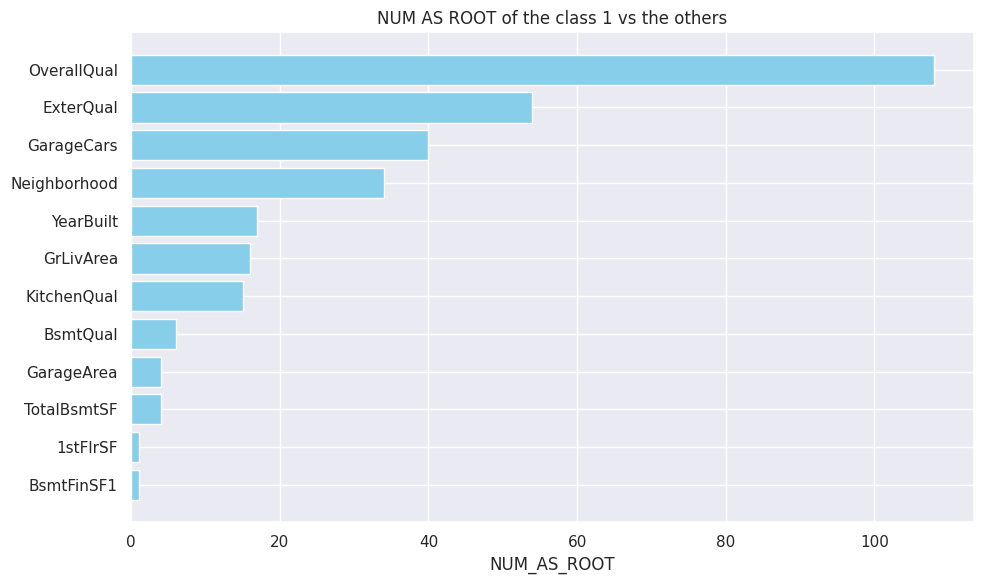

In [ ]:
plt.figure(figsize=(10, 6))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)


plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top

plt.yticks(feature_ranks, feature_names)

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# **Predictions on test data**

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    df_test,
    task = tfdf.keras.Task.REGRESSION)

ids = df_test.index.values

predictions = rf.predict(test_ds)

# create output dataframe with Id and 'SalePrice'
output = pd.DataFrame({'Id': ids,
                       'SalePrice': predictions.squeeze()})

output.head()

2/2 [==============================] - 2s 30ms/step


,Id,SalePrice
0,1461,127023.359375
1,1462,154421.281250
2,1463,183447.453125
3,1464,189633.687500
4,1465,199336.843750


In [ ]:
# Write DataFrame to a CSV file without index
file_name='final_submission_tensorflow.csv'
output.to_csv(file_name, index=False)

In [ ]:
# download CSV file
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>